In [100]:
# Torchvision Data
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

# Other Python Libraries
import matplotlib.pyplot as plt
import numpy as np

# torch related libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

# Use tqdm
from tqdm import tqdm

# Define accuracy function for torch training
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In this notebook, we are going to train our first instance of a Computer Vision algorithm on the famous [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database). This will be used as our first example on how to train a computer vision algorithm from scratch using *pytorch*.

We'll start by loading the dataset below with some transformations for standardization:

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Training data contains around 60000 images that we can classify into some categories. But before we check the images, let's create our train and test *torch* loaders!

We'll use a batch size of 30:

In [79]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30)

Example of the tensors we've generated:

In [80]:
image, label = train_dataset[0]
image, label

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

What's the shape of our tensor?

In [81]:
image.shape

torch.Size([1, 28, 28])

Let's check some examples of our data:

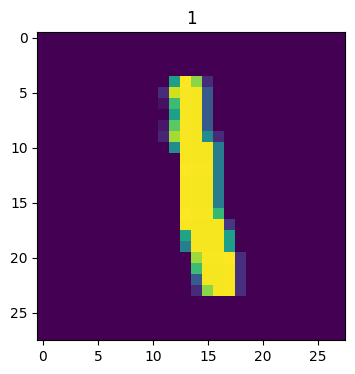

In [92]:
image, label = train_dataset[6]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(label);

The number 1!

Another example:

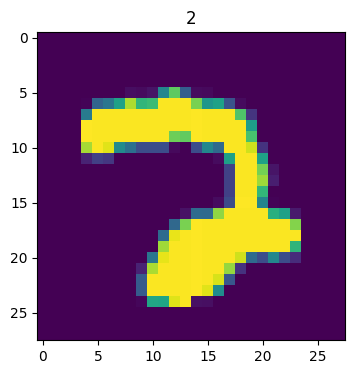

In [91]:
image, label = train_dataset[120]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(label);

Number 2!

I think you get the hand of it - our goal is to use a `torch` model to classify our images - we'll start by defining our data in batches as we've said. We'll use the batches of 3 we've set using `torch loaders`:

In [85]:
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of train dataloader: {len(train_loader)} batches of {train_loader.batch_size}")
print(f"Length of test dataloader: {len(test_loader)} batches of {train_loader.batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000017BFF1FBF50>, <torch.utils.data.dataloader.DataLoader object at 0x0000017BFC1D59D0>)
Length of train dataloader: 2000 batches of 30
Length of test dataloader: 334 batches of 30


In [86]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape

torch.Size([30, 1, 28, 28])

An example of the labels we want to classify in our batch:

In [87]:
train_labels_batch

tensor([0, 0, 3, 9, 2, 0, 2, 3, 0, 2, 5, 2, 9, 5, 6, 0, 0, 6, 2, 7, 4, 5, 3, 7,
        6, 5, 4, 8, 6, 1])

Our class names are the following:

In [94]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

According to our last lectures, we've seen how to create models using non-linearities. Let's try to do that first:

In [93]:
class MNIST_NN(nn.Module):
    def __init__(self, input_shape: int, 
                 hidden_units: int, 
                 output_shape: int):
        super().__init__()
        
        # Create a layer with non-linearities
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

Let's instantiate our model:

In [95]:
model_non_linear = MNIST_NN(input_shape=28*28,
    hidden_units=150,
    output_shape=len(class_names))

# Loss and optimizer are defined next
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

Finally, we can define training and test steps for our Neural Network:

In [96]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.2f} | Train accuracy: {train_acc:.2f}%")

    return train_loss

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

        return test_loss

Let's train our MNIST model for 10 epochs!

In [97]:
loss_hist = {}

# Setup train and test loss history
loss_hist['train'] = {}
loss_hist['test'] = {}

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss = train_step(data_loader=train_loader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    loss_hist['train'][epoch] = train_loss

    test_loss = test_step(data_loader=test_loader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    loss_hist['test'][epoch] = test_loss

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.35 | Train accuracy: 87.10%


 10%|████████▎                                                                          | 1/10 [00:32<04:55, 32.84s/it]

Test loss: 0.34333 | Test accuracy: 87.36%

Epoch: 1
---------
Train loss: 0.34 | Train accuracy: 87.34%


 20%|████████████████▌                                                                  | 2/10 [01:24<05:51, 43.96s/it]

Test loss: 0.33982 | Test accuracy: 87.40%

Epoch: 2
---------
Train loss: 0.25 | Train accuracy: 91.18%


 30%|████████████████████████▉                                                          | 3/10 [02:14<05:26, 46.61s/it]

Test loss: 0.12854 | Test accuracy: 96.20%

Epoch: 3
---------
Train loss: 0.11 | Train accuracy: 97.00%


 40%|█████████████████████████████████▏                                                 | 4/10 [03:06<04:51, 48.65s/it]

Test loss: 0.11742 | Test accuracy: 96.59%

Epoch: 4
---------
Train loss: 0.10 | Train accuracy: 97.19%


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:53<04:00, 48.13s/it]

Test loss: 0.11684 | Test accuracy: 96.59%

Epoch: 5
---------
Train loss: 0.09 | Train accuracy: 97.42%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:38<03:09, 47.28s/it]

Test loss: 0.10796 | Test accuracy: 96.79%

Epoch: 6
---------
Train loss: 0.09 | Train accuracy: 97.56%


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:34<02:29, 50.00s/it]

Test loss: 0.10222 | Test accuracy: 96.90%

Epoch: 7
---------
Train loss: 0.08 | Train accuracy: 97.68%


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:29<01:43, 51.61s/it]

Test loss: 0.10548 | Test accuracy: 96.85%

Epoch: 8
---------
Train loss: 0.08 | Train accuracy: 97.84%


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:16<00:50, 50.19s/it]

Test loss: 0.10076 | Test accuracy: 97.08%

Epoch: 9
---------
Train loss: 0.07 | Train accuracy: 97.95%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:03<00:00, 48.31s/it]

Test loss: 0.09922 | Test accuracy: 97.07%



Model converged in an interesting way, but we see that there is some overfit happening from a certain point onwards:

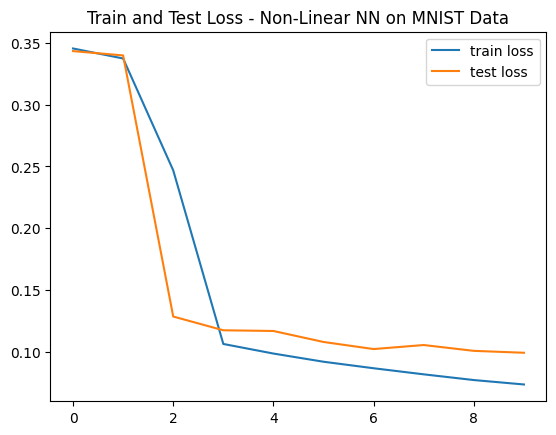

In [99]:
train_loss_hist = [loss_hist['train'][val].item() for val in loss_hist['train']]
test_loss_hist = [loss_hist['test'][val].item() for val in loss_hist['test']]

plt.plot(train_loss_hist)
plt.plot(test_loss_hist)

plt.title('Train and Test Loss - Non-Linear NN on MNIST Data')
plt.legend(['train loss','test loss'])
plt.show()

Let's now try to fit a Convolutional Neural Network using `PyTorch`:

In [66]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5) 
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = SimpleCNN()

Pay attention to the learning rate when creating a CNN! Vanishing or Exploding gradients may enter into play and make your network not converge.

In [102]:
optimizer = torch.optim.SGD(params=net.parameters(),
                            lr=0.05)

And training our CNN:

In [103]:
loss_hist_cnn = {}

loss_hist_cnn['train'] = {}
loss_hist_cnn['test'] = {}

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    loss_cnn = train_step(data_loader=train_loader,
        model=net,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    loss_hist_cnn['train'][epoch] = loss_cnn

    loss_cnn_test = test_step(data_loader=test_loader,
        model=net,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    loss_hist_cnn['test'][epoch] = loss_cnn_test

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.00 | Train accuracy: 99.89%


 10%|████████▏                                                                         | 1/10 [03:38<32:47, 218.65s/it]

Test loss: 0.04240 | Test accuracy: 98.88%

Epoch: 1
---------
Train loss: 0.00 | Train accuracy: 99.97%


 20%|████████████████▍                                                                 | 2/10 [06:51<27:07, 203.43s/it]

Test loss: 0.03646 | Test accuracy: 99.14%

Epoch: 2
---------
Train loss: 0.00 | Train accuracy: 100.00%


 30%|████████████████████████▌                                                         | 3/10 [10:42<25:12, 216.11s/it]

Test loss: 0.03357 | Test accuracy: 99.29%

Epoch: 3
---------
Train loss: 0.00 | Train accuracy: 100.00%


 40%|████████████████████████████████▊                                                 | 4/10 [14:04<21:02, 210.47s/it]

Test loss: 0.03444 | Test accuracy: 99.30%

Epoch: 4
---------
Train loss: 0.00 | Train accuracy: 100.00%


 50%|█████████████████████████████████████████                                         | 5/10 [17:33<17:29, 209.81s/it]

Test loss: 0.03536 | Test accuracy: 99.30%

Epoch: 5
---------
Train loss: 0.00 | Train accuracy: 100.00%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [21:32<14:38, 219.74s/it]

Test loss: 0.03605 | Test accuracy: 99.30%

Epoch: 6
---------
Train loss: 0.00 | Train accuracy: 100.00%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [25:39<11:26, 228.70s/it]

Test loss: 0.03655 | Test accuracy: 99.32%

Epoch: 7
---------
Train loss: 0.00 | Train accuracy: 100.00%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [29:34<07:41, 230.88s/it]

Test loss: 0.03698 | Test accuracy: 99.34%

Epoch: 8
---------
Train loss: 0.00 | Train accuracy: 100.00%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [33:06<03:45, 225.02s/it]

Test loss: 0.03736 | Test accuracy: 99.34%

Epoch: 9
---------
Train loss: 0.00 | Train accuracy: 100.00%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [36:07<00:00, 216.75s/it]

Test loss: 0.03772 | Test accuracy: 99.34%

